In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
config_df = pd.read_csv("bert_classifier_indo.csv")
config_df = config_df.iloc[2:-1]
epoch_df = pd.read_csv("bert_classifier_indo_epoch.csv")
epoch_df.head()
config_df.head()

,config_id,type_test,model_name,dataset_type,batch_size,epochs,learning_rate,attention_dropout,hidden_dropout,classifier_dropout,weight_decay,training_time,peak_memory,test_mse,test_mae,test_rmse,test_pearson
2,2,classifier,indobenchmark/indobert-lite-base-p2,before balancing,16,32,0.00002,0,0,0.1,0.01,6248.815495,4907.419434,0.006936,0.062225,0.083062,0.949350
3,3,classifier,indobenchmark/indobert-lite-base-p2,after balancing,16,17,0.00002,0,0,0.1,0.01,6780.335378,4908.895996,0.008021,0.067400,0.089287,0.943095


# Training Plot

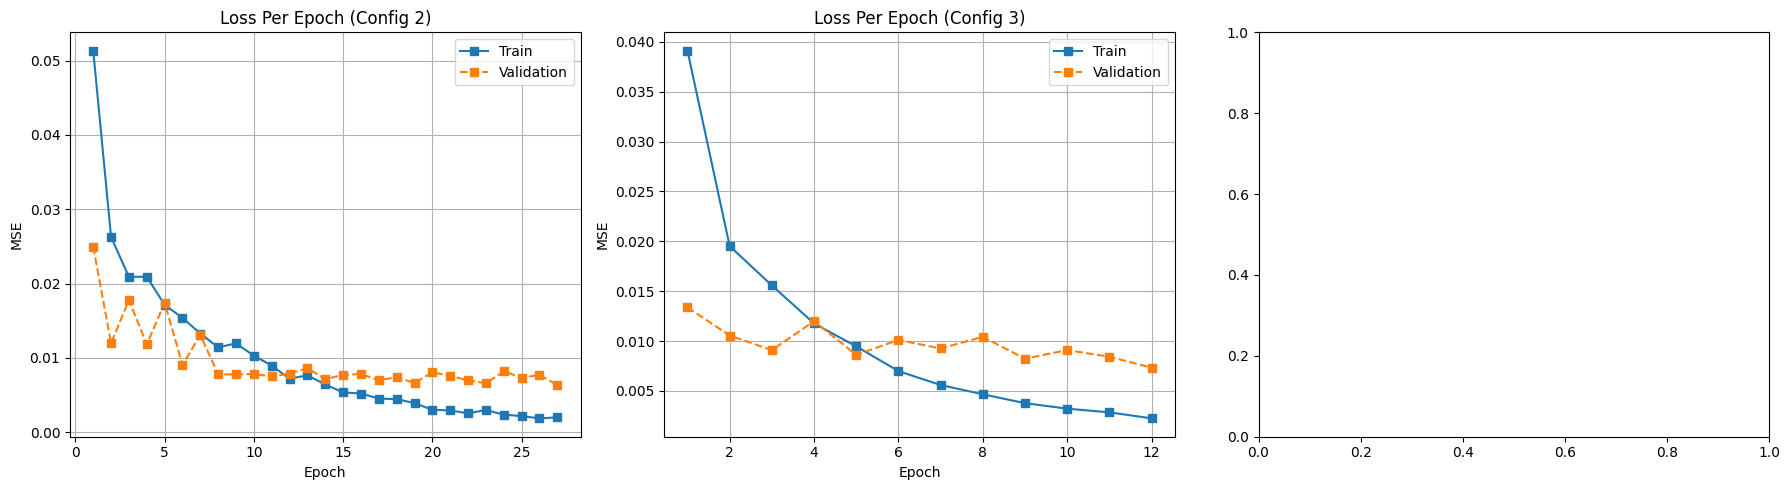

In [38]:
metrics = ['mse']
titles = {
    'mse': 'Loss Per Epoch'
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

for i, row in enumerate(config_df.itertuples(index=False)):
    
    config_id = row.config_id
    data = epoch_df[epoch_df['config_id'] == config_id]
    
    epochs = data['epoch'].iloc[:-5]
    
    for metric in metrics:
        train_metric = data[f'train_{metric}'].iloc[:-5]
        valid_metric = data[f'valid_{metric}'].iloc[:-5]

        ax = axes[i]
        ax.plot(epochs, train_metric, linestyle='-', marker='s', label='Train')
        ax.plot(epochs, valid_metric, linestyle='--', marker='s', label='Validation')
        
        ax.set_title(f"{titles[metric]} (Config {config_id})")
        ax.set_xlabel("Epoch")
        ax.set_ylabel(metric.upper())
        ax.legend()
        ax.grid(True)

plt.tight_layout()
plt.show()


# Scatter Plot with Regression Line

In [39]:
import sys
import os
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..', '..'))
sys.path.append(src_path)
from transformers import BertTokenizer
from main_regression import RegressionModel, AutomaticScoringDataset
from torch.utils.data import DataLoader
import torch

tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-lite-base-p2')
model = RegressionModel('indobenchmark/indobert-lite-base-p2', pooling_type='cls').to('cuda')
def predict(df_test, config_id):
    test_data = AutomaticScoringDataset(df_test, tokenizer)
    test_dataloader = DataLoader(test_data, batch_size=16, shuffle=False, generator=torch.Generator().manual_seed(42), num_workers=0)
    
    checkpoint = torch.load(f"../../../models/balancing/spesific/bert_classifier_indo_{config_id}.pt", map_location='cuda', weights_only=True)
    model.load_state_dict(checkpoint)
    model.eval()
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for batchs in test_dataloader:
            try:
                # move to device
                batchs = {k: v.to('cuda') for k, v in batchs.items()}
                predictions = model(
                    batchs['input_ids'], 
                    batchs['attention_mask'], 
                    batchs['token_type_ids']).squeeze(1)
                preds = torch.clamp(predictions, 0, 1)

                all_predictions.extend(preds.detach().cpu().numpy())
                all_targets.extend(batchs['labels'].detach().cpu().numpy())
            except Exception as e:
                torch.cuda.empty_cache()

    return all_predictions, all_targets

def save_predictions(df_test, output_path):
    columns_to_keep = ['question', 'reference_answer', 'answer', 'normalized_score', 'dataset_num']
    columns_to_keep += [col for col in df_test.columns if col.startswith("predicted_score_")]
    df_test = df_test[columns_to_keep]
    df_test.to_csv(output_path, index=False)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'AlbertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
Some weights of the model checkpoint at indobenchmark/indobert-lite-base-p2 were not used when initializing AlbertModel: ['pooler.bias', 'pooler.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [40]:
import pandas as pd

df_config = pd.read_csv("bert_classifier_indo.csv")
df_config = df_config[2:-1]

df_test = pd.read_csv("../../../../data/clean/spesific/test_indo.csv")
for row in df_config.itertuples():
    all_predictions, all_targets = predict(df_test, row.config_id)

    # Tambahkan prediksi ke df_test
    df_test[f"predicted_score_{row.config_id}"] = all_predictions

output_dir = "inference"
os.makedirs(output_dir, exist_ok=True)

save_predictions(df_test, os.path.join(output_dir, "bert_predictions_indo1.csv"))


>> predicted_score_2
RMSE: 0.0824, Pearson: 0.9501
IQR Outliers: 9

IQR Outliers:
+-----+-------------------+-----------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

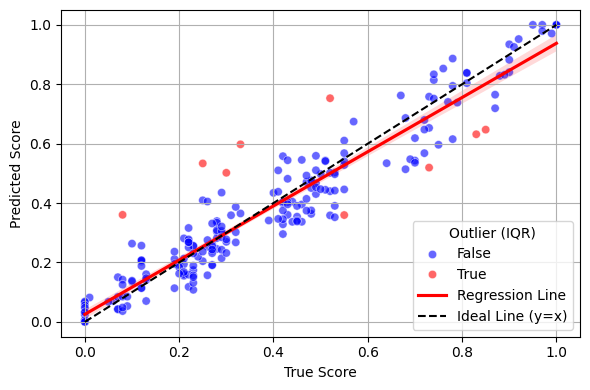


>> predicted_score_3
RMSE: 0.0884, Pearson: 0.9434
IQR Outliers: 8

IQR Outliers:
+-----+-------------------+-----------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

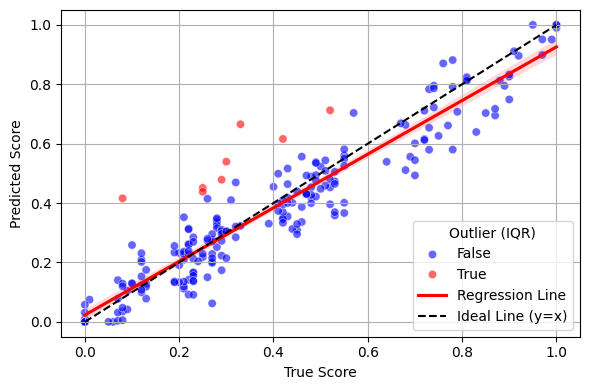

In [ ]:
# import os
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from scipy.stats import pearsonr
# from sklearn.metrics import root_mean_squared_error
# from tabulate import tabulate

# def detect_outliers_from_csv(file_path, pred_col_prefix="predicted_score_"):
#     df = pd.read_csv(file_path)
#     true_scores = df['normalized_score'].values
#     pred_cols = [col for col in df.columns if col.startswith(pred_col_prefix)]

#     for idx, col in enumerate(pred_cols):
#         fig, axes = plt.subplots(1, 1, figsize=(6, 4))
#         pred_scores = df[col].values
#         residuals = pred_scores - true_scores

#         # Metrics
#         rmse = root_mean_squared_error(true_scores, pred_scores)
#         pearson, _ = pearsonr(true_scores, pred_scores)

#         # IQR-based outliers
#         q1 = np.percentile(residuals, 25)
#         q3 = np.percentile(residuals, 75)
#         iqr = q3 - q1
#         lower_bound = q1 - 1.5 * iqr
#         upper_bound = q3 + 1.5 * iqr
#         outliers_iqr = (residuals < lower_bound) | (residuals > upper_bound)

#         # Logging
#         print(f"\n>> {col}")
#         print(f"RMSE: {rmse:.4f}, Pearson: {pearson:.4f}")
#         print(f"IQR Outliers: {np.sum(outliers_iqr)}")

#         # Tambah ke DataFrame
#         df[f'{col}_residual'] = residuals
#         df[f'{col}_outlier_iqr'] = outliers_iqr

#         # === Plotting ===

#         # Kolom 1: Scatter True vs Predicted (STD)
#         ax1 = axes
#         sns.scatterplot(x=true_scores, y=pred_scores, hue=outliers_iqr,
#                         palette={True: 'red', False: 'blue'}, alpha=0.6, ax=ax1)
#         sns.regplot(x=true_scores, y=pred_scores, scatter=False, color='red', ax=ax1, label='Regression Line')
#         ax1.plot([0, 1], [0, 1], 'k--', label='Ideal Line (y=x)')
#         # ax1.set_title("Scatter Plot: True vs Predicted Scores")
#         ax1.set_xlabel("True Score")
#         ax1.set_ylabel("Predicted Score")
#         ax1.legend(title="Outlier (IQR)", loc="lower right")
#         ax1.grid(True)

#         # # Kolom 2: IQR - Boxplot
#         # ax2 = axes[1]
#         # sns.boxplot(x=residuals, ax=ax2, color='lightblue')
#         # ax2.set_title("Boxplot of Residuals")
#         # ax2.set_xlabel("Residual")
#         # ax2.grid(True)

#         # Tampilkan 5 outlier teratas
#         subset_iqr = df[outliers_iqr][['dataset_num', 'question', 'reference_answer', 'answer', 'normalized_score', col]]
#         print("\nIQR Outliers:")
#         print(tabulate(subset_iqr, headers='keys', tablefmt='grid'))

#         if 'dataset_num' in df.columns:
#             grouped = df.groupby('dataset_num')[f'{col}_residual'].apply(lambda x: np.abs(x).mean()).sort_values()

#             # Top 10 soal dengan residual terkecil (ascending)
#             top10_best = grouped.head(10).reset_index()
#             print("\n✅ Soal dengan prediksi terbaik (rata-rata residual terkecil):")
#             print(tabulate(top10_best, headers=['dataset_num', 'Mean Absolute Residual'], tablefmt='grid'))

#             # Top 10 soal dengan residual terbesar (descending)
#             top10_worst = grouped.tail(10).iloc[::-1].reset_index()
#             print("\n⚠️ Soal dengan prediksi terburuk (rata-rata residual terbesar):")
#             print(tabulate(top10_worst, headers=['dataset_num', 'Mean Absolute Residual'], tablefmt='grid'))


#         plt.tight_layout()
#         plt.show()

#     return df

# # Penggunaan
# inference_dir = "inference"
# csv_files = [f for f in os.listdir(inference_dir) if f.endswith(".csv")]

# for file in csv_files:
#     detect_outliers_from_csv(os.path.join(inference_dir, file))



>> DS-4 (Tanpa Augmentasi) - predicted_score_2
RMSE: 0.0824, Pearson: 0.9501

>> DS-5 (Dengan Augmentasi) - predicted_score_3
RMSE: 0.0884, Pearson: 0.9434


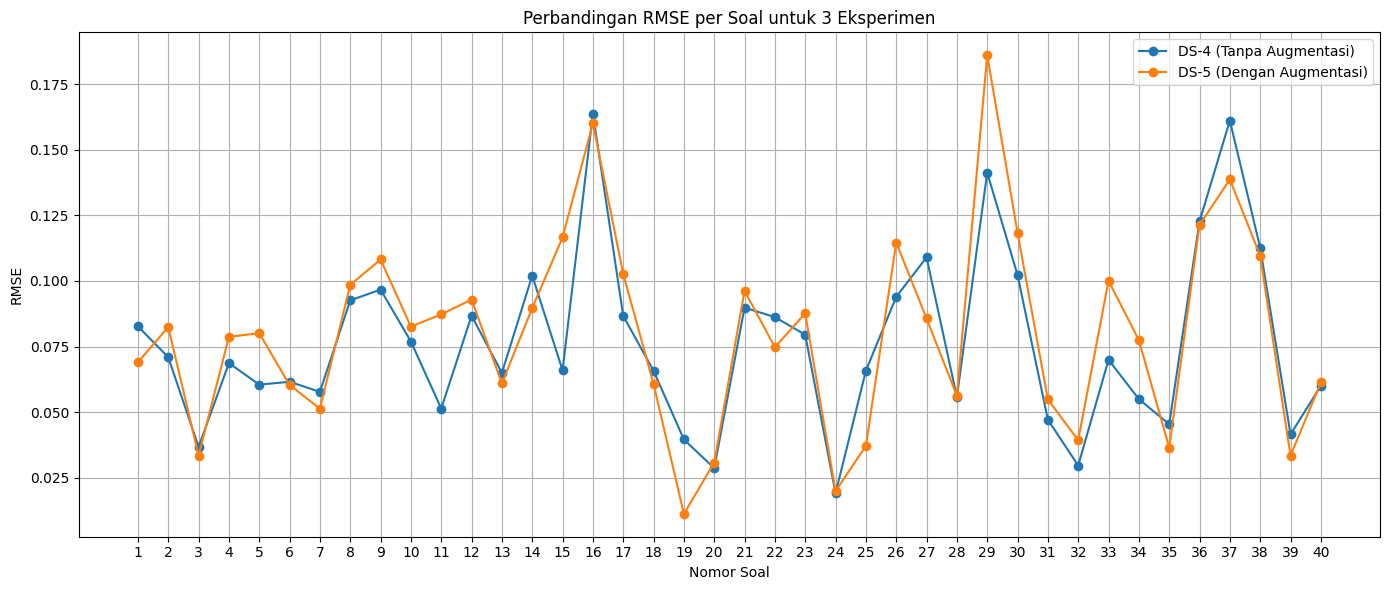

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from scipy.stats import pearsonr
from tabulate import tabulate

# Folder inference
inference_dir = "inference"
csv_files = [f for f in os.listdir(inference_dir) if f.endswith(".csv") and f.startswith("bert")]

# Warna akan di-generate otomatis tergantung jumlah eksperimen
color_palette = plt.get_cmap("tab10")  # Bisa memuat hingga 10 warna berbeda

# Label eksperimen bisa ditentukan manual berdasarkan nama kolom prediksi
label_map = {
    "predicted_score_2": "DS-4 (Tanpa Augmentasi)",
    "predicted_score_3": "DS-5 (Dengan Augmentasi)",
    "predicted_score_4": "DS-6 (Dengan Augmentasi & Tanpa Early Stopping)"
}

# Dictionary untuk menyimpan RMSE per soal dari tiap eksperimen
rmse_per_model = {}
metric_eval_data = {}
# Buat scatter plot dan hitung RMSE per soal
model_idx = 0
for file in csv_files:
    file_path = os.path.join(inference_dir, file)
    df = pd.read_csv(file_path)

    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]

    for col in pred_cols:
        pred_scores = df[col].values
        residuals = pred_scores - true_scores

        # Hitung metrik global
        rmse = root_mean_squared_error(true_scores, pred_scores)
        pearson, _ = pearsonr(true_scores, pred_scores)

        label = label_map.get(col, col)  # Default pakai nama kolom kalau tidak ditemukan
        print(f"\n>> {label} - {col}")
        print(f"RMSE: {rmse:.4f}, Pearson: {pearson:.4f}")

        metric_eval_data[label] = {
            "RMSE": round(rmse, 4),
            "Pearson": round(pearson, 4)
        }

        # Hitung RMSE per soal
        rmse_per_soal = df.groupby('dataset_num').apply(lambda x: root_mean_squared_error(x['normalized_score'], x[col]), include_groups=False)
        rmse_per_model[label] = rmse_per_soal
        model_idx += 1

# Ekstrak nomor soal dari dataset_num (misalnya 'analisis_essay-19' -> 19)
def extract_soal_number(index_series):
    return index_series.astype(str).str.extract(r'(\d+)$').astype(int)[0]

# Plot gabungan RMSE per soal
plt.figure(figsize=(14, 6))
for i, label in enumerate(rmse_per_model):
    rmse_series = rmse_per_model[label]
    
    # Ekstrak nomor soal
    soal_numbers = extract_soal_number(rmse_series.index)
    
    # Gabungkan kembali ke Series dengan index numerik
    rmse_series.index = soal_numbers
    rmse_series = rmse_series.sort_index()
    
    # Plot
    plt.plot(rmse_series.index, rmse_series.values, marker='o', linestyle='-', label=label)

plt.title("Perbandingan RMSE per Soal untuk 3 Eksperimen")
plt.xlabel("Nomor Soal")
plt.ylabel("RMSE")
plt.grid(True)
plt.legend()
plt.xticks(ticks=sorted(rmse_series.index.unique()))  # Lebih rapi dan terbaca
plt.tight_layout()
plt.show()



In [18]:
fixed_threshold = 0.1

# Gabungkan semua residual untuk IQR Global
all_residual_values = []

model_data = []

for file in csv_files:
    df = pd.read_csv(os.path.join(inference_dir, file))
    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]

    for col in pred_cols:
        pred_scores = df[col].values
        residuals = pred_scores - true_scores
        label = label_map.get(col, col)
        model_data.append((label, true_scores, pred_scores, residuals))
        all_residual_values.extend(residuals)

model_data = sorted(model_data, key=lambda x: x[0])

# Hitung IQR global
q1 = np.percentile(all_residual_values, 25)
q3 = np.percentile(all_residual_values, 75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Visualisasi scatter plot untuk tiap model
num_models = len(model_data)
outlier_count = {}
# fig, axes = plt.subplots(num_models, 2, figsize=(14, 5 * num_models))

for i, (label, true_scores, pred_scores, residuals) in enumerate(model_data):
    # Deteksi outlier IQR global & fixed threshold
    outlier_fixed2 = np.abs(residuals) > 0.2
    outlier_fixed = np.abs(residuals) > fixed_threshold

    # # Kolom kiri: IQR Global
    # sns.scatterplot(x=true_scores, y=pred_scores, hue=outlier_iqr,
    #                 palette={True: 'red', False: 'blue'}, alpha=0.6, ax=axes[i, 0])
    # axes[i, 0].plot([0, 1], [0, 1], 'k--', label='Ideal Line (y=x)')
    # axes[i, 0].set_title(f"{label} - Outlier (IQR Global)")
    # axes[i, 0].set_xlabel("True Score")
    # axes[i, 0].set_ylabel("Predicted Score")
    # axes[i, 0].legend(title="Outlier", loc="lower right")
    # axes[i, 0].grid()

    # # Kolom kanan: Fixed Threshold
    # sns.scatterplot(x=true_scores, y=pred_scores, hue=outlier_fixed,
    #                 palette={True: 'red', False: 'blue'}, alpha=0.6, ax=axes[i, 1])
    # axes[i, 1].plot([0, 1], [0, 1], 'k--', label='Ideal Line (y=x)')
    # axes[i, 1].set_title(f"{label} - Outlier (Fixed ±{fixed_threshold})")
    # axes[i, 1].set_xlabel("True Score")
    # axes[i, 1].set_ylabel("Predicted Score")
    # axes[i, 1].legend(title="Outlier", loc="lower right")
    # axes[i, 1].grid()

        # Hitung jumlah outlier
    num_outliers_fixed2 = np.sum(outlier_fixed2)
    num_outliers_fixed = np.sum(outlier_fixed)

    # Cetak hasil
    print(f"{label}:")
    print(f"  Outlier (Fixed ±0.2): {num_outliers_fixed2}")
    print(f"  Outlier (Fixed ±{fixed_threshold}): {num_outliers_fixed}\n")
    outlier_count[label] = {
        "IQR Fixed Threshold ±0.2": num_outliers_fixed2,
        "IQR Fixed Threshold ±0.1": num_outliers_fixed
    }

DS-4 (Tanpa Augmentasi):
  Outlier (Fixed ±0.2): 7
  Outlier (Fixed ±0.1): 43

DS-5 (Dengan Augmentasi):
  Outlier (Fixed ±0.2): 7
  Outlier (Fixed ±0.1): 47



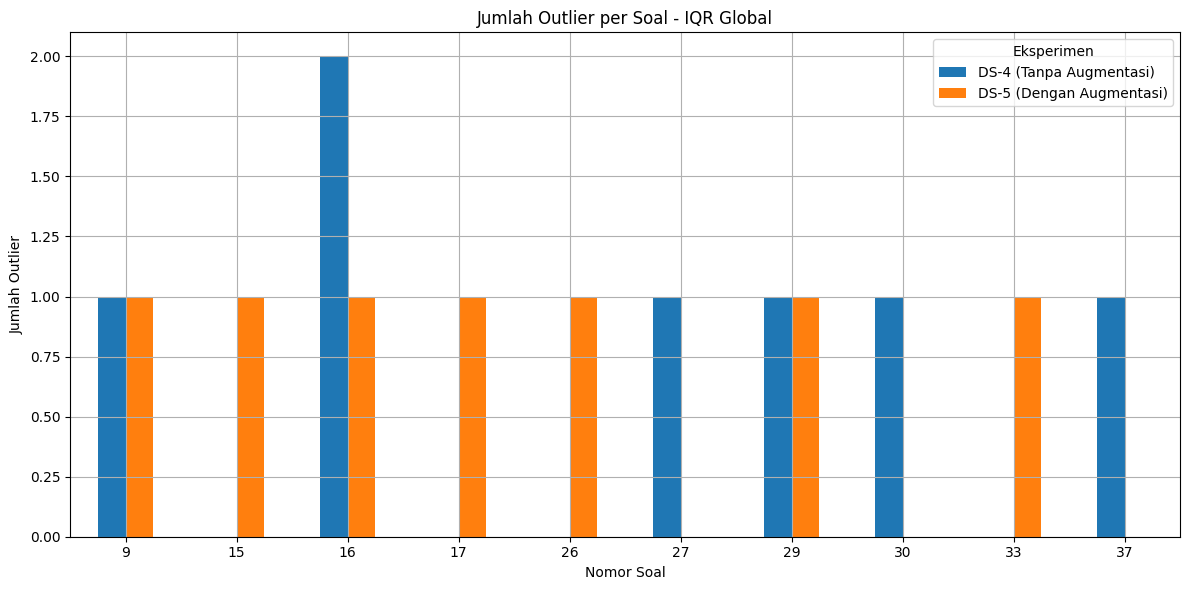

In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Path ke folder berisi file CSV
inference_dir = "inference"
csv_files = [f for f in os.listdir(inference_dir) if f.endswith(".csv")]

# Mapping nama eksperimen
label_map = {
    "predicted_score_2": "DS-4 (Tanpa Augmentasi)",
    "predicted_score_3": "DS-5 (Dengan Augmentasi)",
    "predicted_score_4": "DS-6 (Dengan Augmentasi & Tanpa Early Stopping)"
}

# Step 1: Hitung residual gabungan untuk IQR global
all_residuals = []
outlier_counts_iqr = {}
outlier_counts_fixed = {}

for file in csv_files:
    df = pd.read_csv(os.path.join(inference_dir, file))
    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]

    for col in pred_cols:
        residuals = df[col].values - true_scores
        all_residuals.extend(residuals)

# Step 2: Hitung batas bawah dan atas global IQR
q1 = np.percentile(all_residuals, 25)
q3 = np.percentile(all_residuals, 75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Fixed threshold
fixed_threshold = 0.2

# Step 3: Hitung jumlah outlier per soal (IQR Global & Fixed)
for file in csv_files:
    df = pd.read_csv(os.path.join(inference_dir, file))
    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]
    df['soal_num'] = df['dataset_num'].str.extract(r'-(\d+)$').astype(int)

    for col in pred_cols:
        residuals = df[col].values - true_scores

        outlier_mask_iqr = (residuals < lower_bound) | (residuals > upper_bound)
        outlier_mask_fixed = np.abs(residuals) > fixed_threshold

        df['outlier_iqr'] = outlier_mask_iqr
        df['outlier_fixed'] = outlier_mask_fixed

        label = label_map.get(col, col)

        # IQR Global
        iqr_counts = df[df['outlier_iqr']].groupby('soal_num').size()
        outlier_counts_iqr[label] = iqr_counts

        # Fixed Threshold
        fixed_counts = df[df['outlier_fixed']].groupby('soal_num').size()
        outlier_counts_fixed[label] = fixed_counts

# Step 4: Gabungkan ke DataFrame dan isi kosong dengan nol
df_iqr = pd.DataFrame(outlier_counts_iqr).fillna(0).astype(int).sort_index()
df_fixed2 = pd.DataFrame(outlier_counts_fixed).fillna(0).astype(int).sort_index()

# Plot 1: IQR Global
fig1, ax1 = plt.subplots(figsize=(12, 6))
df_fixed2.plot(kind='bar', ax=ax1)
ax1.set_title("Jumlah Outlier per Soal - IQR Global")
ax1.set_xlabel("Nomor Soal")
ax1.set_ylabel("Jumlah Outlier")
ax1.grid(True)
ax1.legend(title="Eksperimen")
ax1.tick_params(axis='x', rotation=0)
plt.tight_layout()
plt.show()

# # Plot 2: Fixed Threshold dengan ukuran lebih besar
# fig2, ax2 = plt.subplots(figsize=(18, 6))
# df_fixed.plot(kind='bar', ax=ax2)
# ax2.set_title("Jumlah Outlier per Soal - Threshold ±0.1")
# ax2.set_xlabel("Nomor Soal")
# ax2.set_ylabel("Jumlah Outlier")
# ax2.grid(True)
# ax2.legend(title="Eksperimen")
# ax2.tick_params(axis='x', rotation=0)
# plt.tight_layout()
# plt.show()

# from tabulate import tabulate

# # Tampilkan data outlier berdasarkan IQR Global
# print("\n=== DATA OUTLIER BERDASARKAN IQR GLOBAL ===")
# for file in csv_files:
#     df = pd.read_csv(os.path.join(inference_dir, file))
#     true_scores = df['normalized_score'].values
#     pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]
#     df['soal_num'] = df['dataset_num'].str.extract(r'-(\d+)$').astype(int)

#     for col in pred_cols:
#         residuals = df[col].values - true_scores
#         outlier_mask = (residuals < lower_bound) | (residuals > upper_bound)

#         subset_iqr = df[outlier_mask][['dataset_num', 'soal_num', 'question', 'reference_answer', 'answer', 'normalized_score', col]]
#         # subset_iqr = subset_iqr[(subset_iqr['soal_num'] == 27) | (subset_iqr['soal_num'] == 29)]
#         if not subset_iqr.empty:
#             print(f"\nIQR Outliers untuk eksperimen: {label_map.get(col, col)}")
#             print(tabulate(subset_iqr, headers='keys', tablefmt='grid', showindex=False))


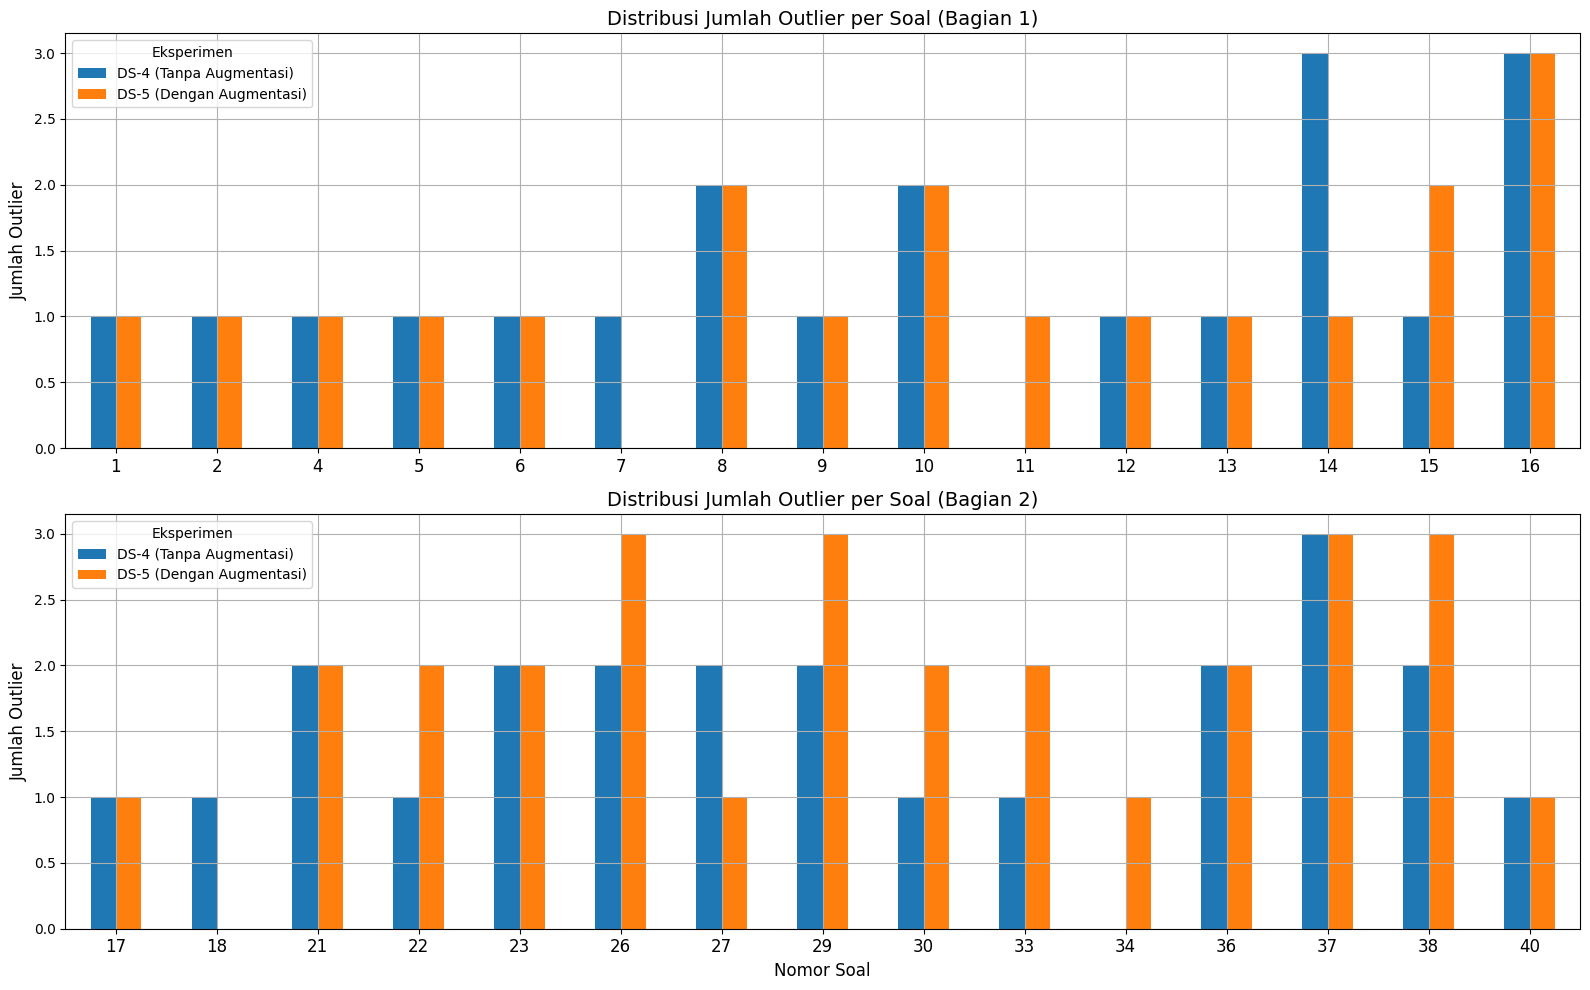

In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Hitung residual gabungan untuk IQR global
all_residuals = []
outlier_counts_iqr = {}
outlier_counts_fixed = {}

for file in csv_files:
    df = pd.read_csv(os.path.join(inference_dir, file))
    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]

    for col in pred_cols:
        residuals = df[col].values - true_scores
        all_residuals.extend(residuals)

# Step 2: Hitung batas bawah dan atas global IQR
q1 = np.percentile(all_residuals, 25)
q3 = np.percentile(all_residuals, 75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Fixed threshold
fixed_threshold = 0.1

# Step 3: Hitung jumlah outlier per soal (IQR Global & Fixed)
for file in csv_files:
    df = pd.read_csv(os.path.join(inference_dir, file))
    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]
    df['soal_num'] = df['dataset_num'].str.extract(r'-(\d+)$').astype(int)

    for col in pred_cols:
        residuals = df[col].values - true_scores

        outlier_mask_iqr = (residuals < lower_bound) | (residuals > upper_bound)
        outlier_mask_fixed = np.abs(residuals) > fixed_threshold

        df['outlier_iqr'] = outlier_mask_iqr
        df['outlier_fixed'] = outlier_mask_fixed

        label = label_map.get(col, col)

        # IQR Global
        iqr_counts = df[df['outlier_iqr']].groupby('soal_num').size()
        outlier_counts_iqr[label] = iqr_counts

        # Fixed Threshold
        fixed_counts = df[df['outlier_fixed']].groupby('soal_num').size()
        outlier_counts_fixed[label] = fixed_counts

# Step 4: Gabungkan ke DataFrame dan isi kosong dengan nol
df_iqr = pd.DataFrame(outlier_counts_iqr).fillna(0).astype(int).sort_index()
df_fixed = pd.DataFrame(outlier_counts_fixed).fillna(0).astype(int).sort_index()

# Plot 1: IQR Fixed - 2 Subplots Vertikal (2 Baris, 1 Kolom)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharey=True)

# Bagi data menjadi dua bagian berdasarkan indeks (yang sudah di-sort)
midpoint = len(df_fixed) // 2
df_fixed_first_half = df_fixed.iloc[:midpoint]
df_fixed_second_half = df_fixed.iloc[midpoint:]

# Subplot 1: Paruh pertama
df_fixed_first_half.plot(kind='bar', ax=ax1)
ax1.set_title("Distribusi Jumlah Outlier per Soal (Bagian 1)", fontsize=14)
ax1.set_xlabel("")  # Kosongkan label x agar tidak duplikat
ax1.set_ylabel("Jumlah Outlier", fontsize=12)
ax1.tick_params(axis='x', labelsize=12, rotation=0)
ax1.grid(True)
ax1.legend(title="Eksperimen")

# Subplot 2: Paruh kedua
df_fixed_second_half.plot(kind='bar', ax=ax2)
ax2.set_title("Distribusi Jumlah Outlier per Soal (Bagian 2)", fontsize=14)
ax2.set_xlabel("Nomor Soal", fontsize=12)
ax2.set_ylabel("Jumlah Outlier", fontsize=12)
ax2.tick_params(axis='x', labelsize=12, rotation=0)
ax2.grid(True)
ax2.legend(title="Eksperimen")

plt.tight_layout()
plt.show()


In [19]:
print("Metrik Evaluation")
print(metric_eval_data)
print("Jumlah Outlier Per Metode IQR")
print(outlier_count)
print("Jumlah Outlier Per Soal Metode IQR Fixed Threshold +-0.1")
print(df_fixed.to_json())
print("Jumlah Outlier Per Soal Metode IQR Fixed Threshold +-0.2")
print(df_fixed2.to_json())

Metrik Evaluation
{'DS-4 (Tanpa Augmentasi)': {'RMSE': 0.0824, 'Pearson': 0.9501}, 'DS-5 (Dengan Augmentasi)': {'RMSE': 0.0884, 'Pearson': 0.9434}}
Jumlah Outlier Per Metode IQR
{'DS-4 (Tanpa Augmentasi)': {'IQR Fixed Threshold ±0.2': 7, 'IQR Fixed Threshold ±0.1': 43}, 'DS-5 (Dengan Augmentasi)': {'IQR Fixed Threshold ±0.2': 7, 'IQR Fixed Threshold ±0.1': 47}}
Jumlah Outlier Per Soal Metode IQR Fixed Threshold +-0.1
{"DS-4 (Tanpa Augmentasi)":{"1":1,"2":1,"4":1,"5":1,"6":1,"7":1,"8":2,"9":1,"10":2,"11":0,"12":1,"13":1,"14":3,"15":1,"16":3,"17":1,"18":1,"21":2,"22":1,"23":2,"26":2,"27":2,"29":2,"30":1,"33":1,"34":0,"36":2,"37":3,"38":2,"40":1},"DS-5 (Dengan Augmentasi)":{"1":1,"2":1,"4":1,"5":1,"6":1,"7":0,"8":2,"9":1,"10":2,"11":1,"12":1,"13":1,"14":1,"15":2,"16":3,"17":1,"18":0,"21":2,"22":2,"23":2,"26":3,"27":1,"29":3,"30":2,"33":2,"34":1,"36":2,"37":3,"38":3,"40":1}}
Jumlah Outlier Per Soal Metode IQR Fixed Threshold +-0.2
{"DS-4 (Tanpa Augmentasi)":{"9":1,"15":0,"16":2,"17":0,"26"

In [13]:
# import json

# interesting_num = [16, 29, 37]
# for file in csv_files:
#     df = pd.read_csv(os.path.join(inference_dir, file))
#     true_scores = df['normalized_score'].values
#     pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]
#     df['soal_num'] = df['dataset_num'].str.extract(r'-(\d+)$').astype(int)

#     for col in pred_cols:
#         residuals = df[col].values - true_scores
#         outlier_mask = np.abs(residuals) > fixed_threshold

#         subset_iqr = df[outlier_mask][['soal_num', 'question', 'reference_answer', 'answer', 'normalized_score', col]]
#         subset_iqr = subset_iqr[subset_iqr['soal_num'].isin(interesting_num)]
#         if not subset_iqr.empty:
#             print(f"\nIQR Outliers untuk eksperimen: {label_map.get(col, col)}")
#             print(subset_iqr.to_json(orient="records", indent=2, force_ascii=False))
